In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from rich import print
import time

from joblib import dump, load

In [2]:
df_sel = pd.read_csv('train_sel_hclust.csv').sample(frac=0.1, random_state=37)

X_train, X_val, y_train, y_val = train_test_split(
    df_sel.drop(['is_benign', 'category', 'attack'], axis=1),
    df_sel['category'], # "category" for multiclass classification
    train_size=0.7,
    random_state=37
)

### Logistic Regression

An high max_iter is necessary for this multiclass in order for the logistic regression to converge to a good optimum

In [3]:
# Define LogisticRegression and parameter grid
log_reg = LogisticRegression(C=1.5, max_iter=20000, random_state = 37)

In [4]:
# Start the time
start_time = time.time()

# Fit the grid search
log_reg.fit(X_train, y_train)

# Stop the timer and print the result
elapsed_time = time.time() - start_time
print(f"\n\nElapsed time {elapsed_time:.2f} seconds")

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Elapsed time 250.19 seconds

In [5]:
y_pred = log_reg.predict(X_val)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='macro')
rec = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

metrics_lr = [
    acc,
    prec,
    rec,
    f1
]
print("\nOverall Report:")
print(f"Accuracy:        {acc:.5f}")
print(f"Precision:       {prec:.5f}")
print(f"Recall:          {rec:.5f}")
print(f"F1:              {f1:.5f}")

print("\n\nDetailed Report:")
print(classification_report(y_val, y_pred))

/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Report:

Accuracy:        0.60311

Precision:       0.41442

Recall:          0.35453

F1:              0.35475

Detailed Report:

/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision    recall  f1-score   support

      BENIGN       0.76      0.41      0.54      1389
        DDoS       0.61      1.00      0.76     33140
         DoS       0.11      0.00      0.00     17680
        MQTT       0.45      0.27      0.34      3226
       RECON       0.00      0.00      0.00      1604
    SPOOFING       0.55      0.45      0.49       494

    accuracy                           0.60     57533
   macro avg       0.41      0.35      0.35     57533
weighted avg       0.43      0.60      0.47     57533

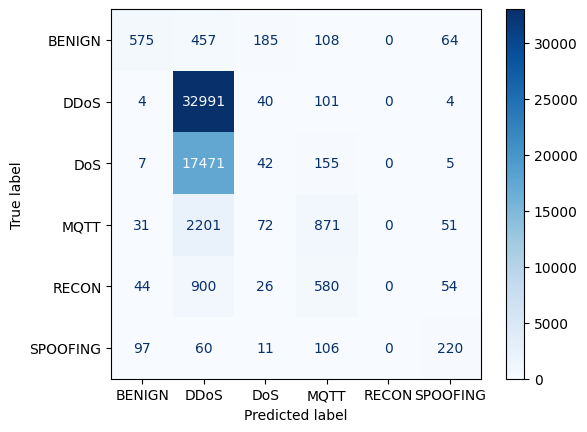

In [6]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()

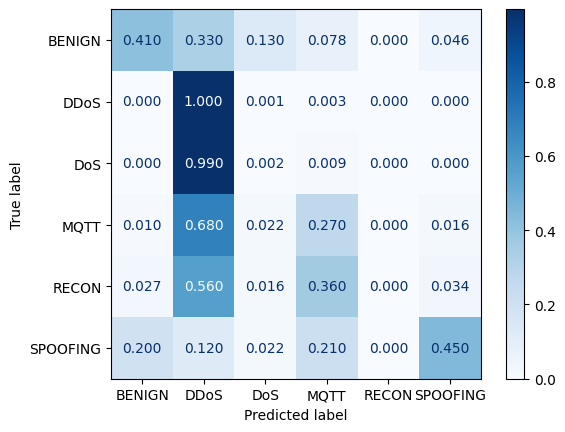

In [7]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true')

# Rounding the decimal points
ax = plt.gca()  # Get current axes
for text in ax.texts:  # Iterate over text annotations
    value = float(text.get_text())  # Get the value of the annotation
    text.set_text(f"{value:.3f}")  # Set the formatted text with 3 decimal points


plt.show()

In [8]:
# Save the model
dump(log_reg, 'log_reg_multiclass.joblib')

['log_reg_multiclass.joblib']

### RandomForest

#### Optimising Hyperparameters

This time, we used a Bayesian Optimisation, with 3-folds cross validation, to choose the best parameters for our model.

This method enables a more intelligent search, since, instead of evaluating all combinations in the parameter grid, it builds a probabilistic model of the performance function and explores the parameter space accordingly. Thus:
- It's possible to assign parameter ranges (for numeric parameters)
- This search method it's more efficient: it needs fewer iterations


In [3]:
# Adjusting our scorer to fit a multiclass classification: using average parameter

from sklearn.metrics import make_scorer

# Define average_score to take y_true and y_pred
def average_score(y_true, y_pred):
    return (accuracy_score(y_true, y_pred) + 
            precision_score(y_true, y_pred, average='macro') + 
            recall_score(y_true, y_pred, average='macro') + 
            f1_score(y_true, y_pred, average='macro')) / 4

# Use make_scorer with the fixed average_score
average_scorer = make_scorer(average_score)

In [4]:
from skopt import BayesSearchCV

# Define RandomForestClassifier
rnd_forest = RandomForestClassifier()

# Define the parameter space for Bayesian optimization
param_space = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': (5, 50),
    'n_estimators': (20,100),
    'random_state': [37]
}

# Set up BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rnd_forest,
    search_spaces=param_space,
    n_iter=25,  # Number of parameter combinations to evaluate
    cv=3,
    scoring=average_scorer,  # Our custom scoring metric
    verbose=0,
    random_state=37,
    n_jobs=-1  # Use all available cores
)

In [5]:
# Start the time
start_time = time.time()

# Fit the Bayesian optimization
bayes_search.fit(X_train, y_train)

# Stop the timer and print the result
elapsed_time = time.time() - start_time
print(f"\n\nElapsed time {elapsed_time:.2f} seconds")
# Access the best model and parameters
best_model = bayes_search.best_estimator_
print("\nBest Parameters by Bayesian Optimization:", bayes_search.best_params_)

Elapsed time 4097.92 seconds

Best Parameters by Bayesian Optimization:
OrderedDict([('criterion', 'log_loss'), ('max_depth', 24), ('n_estimators', 100), ('random_state', 37)])

#### Prediction and Evaluation

In [6]:
y_pred = best_model.predict(X_val)

In [7]:
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='macro')
rec = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

metrics_rnd = [
    acc,
    prec,
    rec,
    f1
]
print("\nOverall Report:")
print(f"Accuracy:        {acc:.5f}")
print(f"Precision:       {prec:.5f}")
print(f"Recall:          {rec:.5f}")
print(f"F1:              {f1:.5f}")

print("\n\nDetailed Report:")
print(classification_report(y_val, y_pred))

Overall Report:

Accuracy:        0.99773

Precision:       0.97756

Recall:          0.97795

F1:              0.97771

Detailed Report:

precision    recall  f1-score   support

      BENIGN       0.96      0.98      0.97     13456
        DDoS       1.00      1.00      1.00    330818
         DoS       1.00      1.00      1.00    178133
        MQTT       1.00      1.00      1.00     32389
       RECON       0.99      0.97      0.98     15717
    SPOOFING       0.92      0.92      0.92      4811

    accuracy                           1.00    575324
   macro avg       0.98      0.98      0.98    575324
weighted avg       1.00      1.00      1.00    575324

##### Confusion Matrix with raw counts

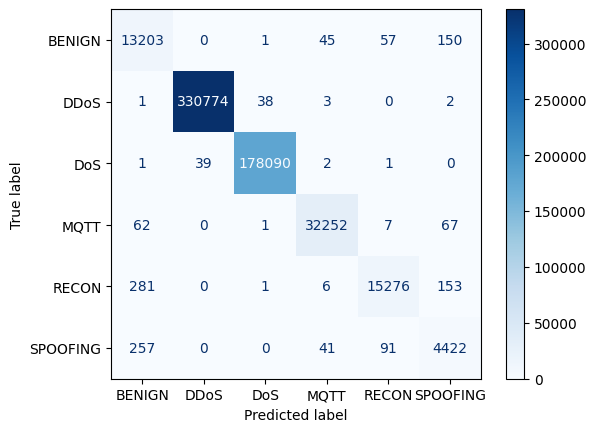

In [8]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()

##### Confusion Matrix with normalised counts

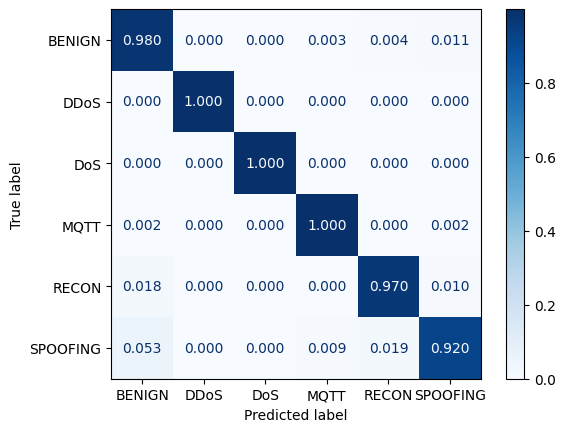

In [9]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true')

# Rounding the decimal points
ax = plt.gca()  # Get current axes
for text in ax.texts:  # Iterate over text annotations
    value = float(text.get_text())  # Get the value of the annotation
    text.set_text(f"{value:.3f}")  # Set the formatted text with 3 decimal points


plt.show()

In [11]:
# Save the model
dump(best_model, 'rnd_forest_multiclass.joblib')

['rnd_forest_multiclass.joblib']